================== From Fully Connected Layers to Convolutions ==================

### Invariance

The chapter motivates CNNs through the "Where's Waldo" analogy. Three key principles for image processing:

1. **Translation Invariance**: The network should respond similarly regardless of WHERE an object appears in the image
2. **Locality**: Early layers should focus on local regions, not distant pixels
3. **Hierarchical Features**: Deeper layers capture longer-range features by aggregating local information

### Constraining the MLP

#### Starting Point: Fully Connected Layer

For a 2D image input $\mathbf{X}$ and hidden representation $\mathbf{H}$, a fully connected layer would be:

$$[\mathbf{H}]_{i, j} = [\mathbf{U}]_{i, j} + \sum_k \sum_l [\mathsf{W}]_{i, j, k, l} [\mathbf{X}]_{k, l}$$

where:
- $[\mathbf{X}]_{i,j}$ is the pixel at position $(i, j)$
- $[\mathsf{W}]_{i,j,k,l}$ are the weights connecting input $(k, l)$ to output $(i, j)$
- $[\mathbf{U}]_{i,j}$ is the bias

**Problem**: For a $1000 \times 1000$ image, this requires $10^{12}$ parameters!

#### Translation Invariance

We invoke the first principle: the detector should work the same regardless of position.

Reindex by setting $a = k - i$ and $b = l - j$:

$$[\mathbf{H}]_{i, j} = [\mathbf{U}]_{i, j} + \sum_a \sum_b [\mathsf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}$$

Key insight: $\mathsf{V}$ no longer depends on $(i, j)$ — **weights are shared across all positions**.

This is a **convolution**! We weight pixels at $(i+a, j+b)$ near $(i, j)$ using coefficients $[\mathsf{V}]_{a, b}$.

#### Locality

We invoke the second principle: only nearby pixels matter for local features.

Restrict the sum to a local neighborhood of size $\Delta$:

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}$$

**Parameter reduction**: From $4 \times 10^6$ parameters to $(2\Delta + 1)^2$ parameters (e.g., $4 \times 10^4$ for typical kernel sizes).

This is a **convolutional layer** — the foundation of CNNs.

### Convolutions

#### Mathematical Definition

**Continuous convolution**:
$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x} - \mathbf{z}) \, d\mathbf{z}$$

**Discrete convolution (1D)**:
$$(f * g)(i) = \sum_a f(a) g(i - a)$$

**Discrete convolution (2D)**:
$$(f * g)(i, j) = \sum_a \sum_b f(a, b) g(i - a, j - b)$$

#### Convolution vs Cross-Correlation

Note the sign difference between:
- **Convolution**: $g(i - a, j - b)$
- **Cross-correlation**: $g(i + a, j + b)$

Our formula in Locality section is technically a **cross-correlation**, but in deep learning we call it "convolution" by convention. The difference doesn't matter because the kernel weights are learned.

### Channels

Real images have multiple input channels (e.g., RGB = 3 channels). We extend to handle this:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}$$

where:
- $c$ indexes **input channels** (e.g., R, G, B)
- $d$ indexes **output channels** (feature maps in the hidden layer)
- $[\mathsf{V}]_{a, b, c, d}$ is a 4D tensor of learnable parameters

This is the **general form of a convolutional layer**.

### Summary

| Aspect | Fully Connected | Convolutional |
|--------|-----------------|---------------|
| **Parameters** | $O(n^4)$ for $n \times n$ images | $O(\Delta^2 \cdot c_{in} \cdot c_{out})$ |
| **Translation Invariance** | No | Yes (weight sharing) |
| **Locality** | No (all pixels connected) | Yes (kernel size $\Delta$) |
| **Inductive Bias** | None | Matches image structure |

### Key Principles Derived:

1. **Translation Invariance** → **Weight Sharing**: Same kernel applied everywhere
2. **Locality** → **Small Kernels**: Only neighboring pixels influence each output
3. **Channels** → **Feature Maps**: Multiple learned filters capture different patterns

### Why This Matters:

- **Massive parameter reduction**: Makes training feasible on images
- **Built-in inductive bias**: Reflects true structure of visual data
- **Hierarchical learning**: 
  - Early layers: edges, textures
  - Middle layers: parts, patterns
  - Deep layers: objects, scenes

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

========================= Convolutions for Images ===========================

### The Cross-Correlation Operation

Strictly speaking, convolutional layers perform **cross-correlation**, not convolution (the kernel is not flipped).

#### How It Works

Given:
- Input tensor $\mathbf{X}$ of shape $(n_h \times n_w)$
- Kernel tensor $\mathbf{K}$ of shape $(k_h \times k_w)$

The kernel slides over the input, computing element-wise products and summing:

**Example**
!["2d cross-correlation"](./Images/7/2d-cross-correlation.png)

#### Output Size Formula

$$\text{Output size} = (n_h - k_h + 1) \times (n_w - k_w + 1)$$

For the example: $(3-2+1) \times (3-2+1) = 2 \times 2$

### Convolutional Layers

A convolutional layer consists of:
1. **Kernel (weights)**: Learnable parameters
2. **Bias**: Scalar added to output

$$\mathbf{Y} = \text{corr2d}(\mathbf{X}, \mathbf{K}) + b$$

An $h \times w$ convolution (or $h \times w$ convolution kernel) refers to a kernel of height $h$ and width $w$.

### Object Edge Detection in Images

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

#### Example: Vertical Edge Detection

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
# Kernel: 1 * 2 edge detector

K = torch.tensor([[1.0, -1.0]])

**Output**: Detects transitions
- White-to-black edge: outputs $1$
- Black-to-white edge: outputs $-1$
- No change: outputs $0$

**Key insight**: This kernel only detects **vertical** edges. Applying it to the transposed image (horizontal edges) produces all zeros.

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
# apply the kernel to the transposed image. As expected, it vanishes.
#  The kernel K only detects vertical edges.

corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### Learning a Kernel

Instead of hand-designing kernels, we can **learn** them from data.
we can learn the kernel that generated Y from X by looking at the input–output pairs only.

In [9]:

# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

# After training, the learned kernel approximates $[1, -1]$.
conv2d.weight.data.reshape((1, 2))

epoch 2, loss 5.448
epoch 4, loss 0.917
epoch 6, loss 0.155
epoch 8, loss 0.026
epoch 10, loss 0.005


/workspaces/pytorch-d2l/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[ 0.9861, -0.9897]])

### Cross-Correlation and Convolution

#### Mathematical Difference

**Cross-correlation**:
$$(\mathbf{X} \star \mathbf{K})_{i,j} = \sum_a \sum_b \mathbf{K}_{a,b} \cdot \mathbf{X}_{i+a, j+b}$$

**True convolution** (kernel flipped):
$$(\mathbf{X} * \mathbf{K})_{i,j} = \sum_a \sum_b \mathbf{K}_{a,b} \cdot \mathbf{X}_{i-a, j-b}$$

#### Why It Doesn't Matter

- Flipping the kernel $\mathbf{K}$ gives $\mathbf{K}'$
- Cross-correlation with $\mathbf{K}' =$ Convolution with $\mathbf{K}$
- Since kernels are **learned**, the network learns the appropriate (possibly flipped) version

**Convention**: Deep learning uses "convolution" to mean cross-correlation.


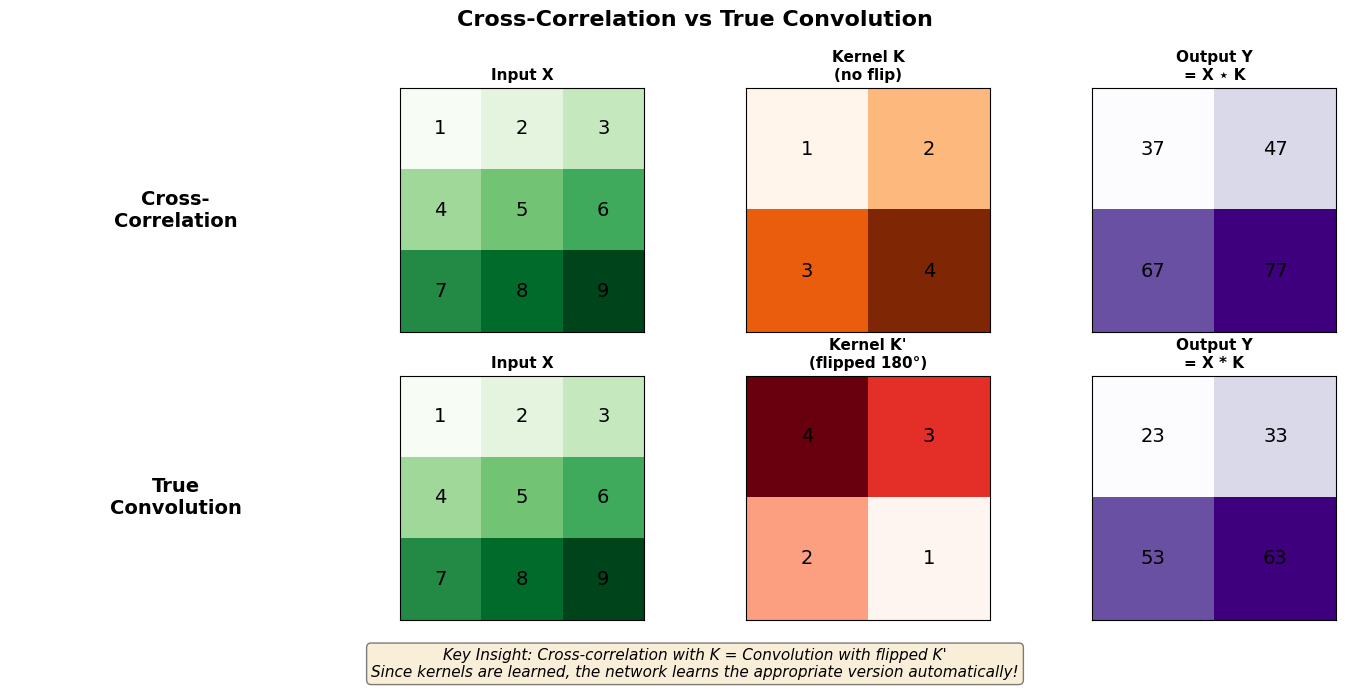

MATHEMATICAL DETAILS

Original Kernel K:
[[1. 2.]
 [3. 4.]]

Flipped Kernel K' (rotated 180°):
[[4. 3.]
 [2. 1.]]

Cross-Correlation (X ⋆ K):
  Position (0,0): 1.0×1.0 + 2.0×2.0 + 4.0×3.0 + 5.0×4.0
              = 1.0 + 4.0 + 12.0 + 20.0 = 37

True Convolution (X * K) using flipped kernel:
  Position (0,0): 1.0×4.0 + 2.0×3.0 + 4.0×2.0 + 5.0×1.0
              = 4.0 + 6.0 + 8.0 + 5.0 = 23


In [10]:
# Add this cell before the "### Feature Map and Receptive Field" markdown cell

import matplotlib.pyplot as plt
import numpy as np

def visualize_cross_correlation_vs_convolution():
    """Visualize the difference between cross-correlation and convolution."""
    
    # Create a simple input and kernel
    X = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=float)
    
    K = np.array([[1, 2],
                  [3, 4]], dtype=float)
    
    # Flipped kernel (for true convolution)
    K_flipped = np.flip(np.flip(K, axis=0), axis=1)  # Flip both axes
    
    # Compute cross-correlation: K[a,b] * X[i+a, j+b]
    def cross_correlation(X, K):
        h, w = K.shape
        out_h, out_w = X.shape[0] - h + 1, X.shape[1] - w + 1
        Y = np.zeros((out_h, out_w))
        for i in range(out_h):
            for j in range(out_w):
                Y[i, j] = np.sum(X[i:i+h, j:j+w] * K)
        return Y
    
    # Cross-correlation result
    Y_cross = cross_correlation(X, K)
    
    # True convolution = cross-correlation with flipped kernel
    Y_conv = cross_correlation(X, K_flipped)
    
    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    
    # Helper function to annotate matrices
    def annotate_matrix(ax, matrix, title, color='Blues'):
        im = ax.imshow(matrix, cmap=color, aspect='equal')
        ax.set_title(title, fontsize=11, fontweight='bold')
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, f'{matrix[i,j]:.0f}', ha='center', va='center', 
                       fontsize=14, color='black')
        ax.set_xticks([])
        ax.set_yticks([])
        return im
    
    # Row 1: Cross-Correlation
    axes[0, 0].text(0.5, 0.5, 'Cross-\nCorrelation', fontsize=14, ha='center', 
                    va='center', fontweight='bold', transform=axes[0, 0].transAxes)
    axes[0, 0].axis('off')
    
    annotate_matrix(axes[0, 1], X, 'Input X', 'Greens')
    annotate_matrix(axes[0, 2], K, 'Kernel K\n(no flip)', 'Oranges')
    annotate_matrix(axes[0, 3], Y_cross, 'Output Y\n= X ⋆ K', 'Purples')
    
    # Row 2: True Convolution
    axes[1, 0].text(0.5, 0.5, 'True\nConvolution', fontsize=14, ha='center', 
                    va='center', fontweight='bold', transform=axes[1, 0].transAxes)
    axes[1, 0].axis('off')
    
    annotate_matrix(axes[1, 1], X, 'Input X', 'Greens')
    annotate_matrix(axes[1, 2], K_flipped, "Kernel K'\n(flipped 180°)", 'Reds')
    annotate_matrix(axes[1, 3], Y_conv, "Output Y\n= X * K", 'Purples')
    
    # Add arrows and explanations
    fig.text(0.5, 0.95, 'Cross-Correlation vs True Convolution', fontsize=16, 
             ha='center', fontweight='bold')
    
    fig.text(0.5, 0.02, 
             "Key Insight: Cross-correlation with K = Convolution with flipped K'\n"
             "Since kernels are learned, the network learns the appropriate version automatically!",
             fontsize=11, ha='center', style='italic',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.93])
    plt.show()
    
    # Print the mathematical details
    print("=" * 60)
    print("MATHEMATICAL DETAILS")
    print("=" * 60)
    print(f"\nOriginal Kernel K:\n{K}")
    print(f"\nFlipped Kernel K' (rotated 180°):\n{K_flipped}")
    print(f"\nCross-Correlation (X ⋆ K):")
    print(f"  Position (0,0): {X[0,0]}×{K[0,0]} + {X[0,1]}×{K[0,1]} + {X[1,0]}×{K[1,0]} + {X[1,1]}×{K[1,1]}")
    print(f"              = {X[0,0]*K[0,0]} + {X[0,1]*K[0,1]} + {X[1,0]*K[1,0]} + {X[1,1]*K[1,1]} = {Y_cross[0,0]:.0f}")
    print(f"\nTrue Convolution (X * K) using flipped kernel:")
    print(f"  Position (0,0): {X[0,0]}×{K_flipped[0,0]} + {X[0,1]}×{K_flipped[0,1]} + {X[1,0]}×{K_flipped[1,0]} + {X[1,1]}×{K_flipped[1,1]}")
    print(f"              = {X[0,0]*K_flipped[0,0]} + {X[0,1]*K_flipped[0,1]} + {X[1,0]*K_flipped[1,0]} + {X[1,1]*K_flipped[1,1]} = {Y_conv[0,0]:.0f}")

visualize_cross_correlation_vs_convolution()

### Feature Map and Receptive Field

#### Feature Map
The output of a convolutional layer is called a **feature map** — it represents learned spatial features of the input.

#### Receptive Field

The **receptive field** of an output element is the region in the input that affects its computation.

- For a single $k \times k$ conv layer: receptive field = $k \times k$
- For stacked layers: receptive field grows with depth

**Biological inspiration**: Named after neuroscience concept — neurons in visual cortex respond to specific regions of the visual field (Hubel & Wiesel, Nobel Prize 1981).

#### Deep Networks and Receptive Fields

With each convolutional layer, the receptive field grows:
- Layer 1: $k \times k$
- Layer 2: $(2k-1) \times (2k-1)$
- Layer $n$: receptive field increases, capturing larger-scale patterns

This is why **deep** CNNs can recognize complex objects — early layers detect edges, deeper layers detect parts, even deeper layers detect whole objects.

### Summary Table

| Concept | Formula/Description |
|---------|---------------------|
| Cross-correlation | $\sum_a \sum_b K_{a,b} \cdot X_{i+a, j+b}$ |
| Output size | $(n_h - k_h + 1) \times (n_w - k_w + 1)$ |
| Convolutional layer | $Y = \text{corr2d}(X, K) + b$ |
| Edge detection kernel | $[1, -1]$ for vertical edges |
| Receptive field | Input region affecting one output element |

### Key Takeaways

1. **Cross-correlation** is the actual operation (kernel not flipped), but called "convolution" by convention
2. **Kernels can be learned** — no need for manual design
3. **Feature maps** are spatial representations of detected patterns
4. **Receptive field** grows with network depth, enabling hierarchical feature learning
5. **Edge detection** is a simple but powerful example of what convolutions can do

========================= Padding and Strides ===========================

### Padding

#### The Problem: Shrinking Outputs

With a $(n_h \times n_w)$ input and $(k_h \times k_w)$ kernel, the output size is:
$$(n_h - k_h + 1) \times (n_w - k_w + 1)$$

**Issues:**
1. **Output shrinks** with each layer — limits network depth
2. **Boundary pixels** are used less than center pixels — loses information at edges

#### Solution: Padding

Add extra pixels (usually zeros) around the input border.

**With padding $p_h$ (height) and $p_w$ (width):**
$$(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)$$

#### Common Choice: "Same" Padding

To keep output size = input size, set:
$$p_h = k_h - 1, \quad p_w = k_w - 1$$

For odd kernel sizes (e.g., $3 \times 3$, $5 \times 5$):
- Pad equally on both sides: $p_h/2$ on top/bottom, $p_w/2$ on left/right

**Why odd kernels?** 
- Symmetric padding on both sides
- Clear center pixel for the kernel
- Convention: $1 \times 1$, $3 \times 3$, $5 \times 5$, $7 \times 7$ are most common

In [11]:
import torch
from torch import nn

# Helper function to compute convolution and return output shape
def comp_conv2d(conv2d, X):
    """Compute conv2d and return output after removing batch and channel dims."""
    # Add batch dimension (1) and channel dimension (1)
    # PyTorch expects (batch, channel, height, width)
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Remove batch and channel dimensions for display
    return Y.reshape(Y.shape[2:])

# Example: 8x8 input with 3x3 kernel and padding=1
# With padding=1 and kernel=3: output = 8 - 3 + 2*1 + 1 = 8 (same as input!)
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
print(f"Input shape: {X.shape}")
print(f"Output shape: {comp_conv2d(conv2d, X).shape}")
print("✓ Output size equals input size (same padding)")

Input shape: torch.Size([8, 8])
Output shape: torch.Size([8, 8])
✓ Output size equals input size (same padding)


In [12]:
# Asymmetric padding: different padding for height and width
# Kernel: 5x3, Padding: (2, 1) -> pad 2 on height (top/bottom), 1 on width (left/right)
# Output height: 8 - 5 + 2*2 + 1 = 8
# Output width:  8 - 3 + 2*1 + 1 = 8
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
print(f"Kernel: 5x3, Padding: (2, 1)")
print(f"Input shape: {X.shape}")
print(f"Output shape: {comp_conv2d(conv2d, X).shape}")  # Still 8x8
print("✓ Asymmetric kernel with asymmetric padding maintains size")

Kernel: 5x3, Padding: (2, 1)
Input shape: torch.Size([8, 8])
Output shape: torch.Size([8, 8])
✓ Asymmetric kernel with asymmetric padding maintains size


### Stride

#### Motivation

For computational efficiency or to downsample, we can **skip positions** when sliding the kernel.

**Stride**: The number of rows/columns we slide per step (default = 1).

#### Output Size with Stride

With stride $(s_h, s_w)$ and padding $(p_h, p_w)$:

$$\left\lfloor\frac{n_h - k_h + p_h + s_h}{s_h}\right\rfloor \times \left\lfloor\frac{n_w - k_w + p_w + s_w}{s_w}\right\rfloor$$

**Simplified** (when $p_h = k_h - 1$ and $p_w = k_w - 1$):
$$\left\lfloor\frac{n_h + s_h - 1}{s_h}\right\rfloor \times \left\lfloor\frac{n_w + s_w - 1}{s_w}\right\rfloor$$

**Special case** (input divisible by stride):
$$\frac{n_h}{s_h} \times \frac{n_w}{s_w}$$


| Parameter | Effect | Common Values |
|-----------|--------|---------------|
| **Padding** | Increases output size, preserves border info | $p = (k-1)/2$ for "same" |
| **Stride** | Decreases output size, reduces computation | 1 (default), 2 (downsample) |

In [13]:
# Stride example: 3x3 kernel with stride=2
# Output: floor((8 - 3 + 2*1 + 2) / 2) = floor(9/2) = 4
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
print(f"Input: 8x8, Kernel: 3x3, Padding: 1, Stride: 2")
print(f"Output shape: {comp_conv2d(conv2d, X).shape}")  # 4x4 (halved!)
print("✓ Stride=2 halves the spatial dimensions")

Input: 8x8, Kernel: 3x3, Padding: 1, Stride: 2
Output shape: torch.Size([4, 4])
✓ Stride=2 halves the spatial dimensions


In [14]:
# Complex example: asymmetric kernel, padding, and stride
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
print(f"Kernel: 3x5, Padding: (0, 1), Stride: (3, 4)")
print(f"Output shape: {comp_conv2d(conv2d, X).shape}")

# Verify with formula:
# Height: floor((8 - 3 + 0*2 + 3) / 3) = floor(8/3) = 2
# Width:  floor((8 - 5 + 1*2 + 4) / 4) = floor(9/4) = 2
print("\nManual calculation:")
print("  Height: floor((8 - 3 + 0 + 3) / 3) = floor(8/3) = 2")
print("  Width:  floor((8 - 5 + 2 + 4) / 4) = floor(9/4) = 2")

Kernel: 3x5, Padding: (0, 1), Stride: (3, 4)
Output shape: torch.Size([2, 2])

Manual calculation:
  Height: floor((8 - 3 + 0 + 3) / 3) = floor(8/3) = 2
  Width:  floor((8 - 5 + 2 + 4) / 4) = floor(9/4) = 2


#### Output Size Formula (Complete)

**Goal**: Given input size, padding, kernel size, and stride, determine how many output positions exist.

**Assumptions**:
- The input is a 1D sequence or a single spatial dimension (height or width); the same formula applies independently to each dimension
- Padding $p$ is applied equally on both sides (total padding = $2p$)
- The kernel must fit entirely within the (padded) input at each position
- We only count valid positions where the kernel doesn't extend beyond boundaries

**Derivation**:
1. After padding, the effective input size becomes $n + 2p$
2. The kernel of size $k$ needs $k$ positions, so the last valid starting position is at $(n + 2p) - k$
3. Starting from position 0, with stride $s$, we can place the kernel at positions $0, s, 2s, \ldots$
4. The number of valid positions = $\lfloor \frac{(n + 2p) - k}{s} \rfloor + 1$

$$\text{Output} = \left\lfloor\frac{n + 2p - k}{s}\right\rfloor + 1$$

where $n$ = input size, $p$ = padding, $k$ = kernel size, $s$ = stride

#### Design Guidelines

1. **Use odd kernel sizes** (3, 5, 7) for symmetric padding
2. **Padding = (kernel_size - 1) / 2** keeps output size = input size (when stride=1)
3. **Stride > 1** for downsampling (alternative to pooling)
4. **Stride = 2** halves the spatial dimensions

#### Key Takeaways

- **Padding** controls output size and preserves edge information
- **Stride** controls downsampling rate and computational cost
- Together they give fine-grained control over feature map dimensions
- Most modern architectures: $3 \times 3$ kernels, padding=1, stride=1 or 2

========================= Multiple Input and Multiple Output Channels ===========================

### Multiple Input Channels

#### Why Multiple Input Channels?

Real images have **multiple channels** (e.g., RGB = 3 channels). Each channel may contain different information:
- **R, G, B**: Color intensity
- **Depth**: Distance from camera
- **Feature maps**: From previous layers

#### How It Works

For input with $c_i$ channels:
- Input $\mathbf{X}$: shape $(c_i \times n_h \times n_w)$
- Kernel $\mathbf{K}$: shape $(c_i \times k_h \times k_w)$ — one 2D kernel per input channel
- Output $\mathbf{Y}$: shape $(n_h - k_h + 1) \times (n_w - k_w + 1)$ — single channel

**Computation**: Cross-correlate each input channel with its corresponding kernel, then **sum** the results:

$$\mathbf{Y} = \sum_{i=0}^{c_i-1} \mathbf{X}_i \star \mathbf{K}_i$$

In [15]:
import torch

def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

def corr2d_multi_in(X, K):
    """Cross-correlation with multiple input channels.
    
    Args:
        X: Input tensor of shape (c_i, h, w) - multiple input channels
        K: Kernel tensor of shape (c_i, k_h, k_w) - one kernel per input channel
    
    Returns:
        Output tensor of shape (h - k_h + 1, w - k_w + 1) - single channel output
    """
    # Cross-correlate each channel and sum the results
    return sum(corr2d(x, k) for x, k in zip(X, K))

# Example: 2 input channels
X = torch.tensor([[[0.0, 1.0, 2.0],   # Channel 0
                   [3.0, 4.0, 5.0],
                   [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0],   # Channel 1
                   [4.0, 5.0, 6.0],
                   [7.0, 8.0, 9.0]]])

# Kernel: 2 input channels, each 2x2
K = torch.tensor([[[0.0, 1.0],        # Kernel for channel 0
                   [2.0, 3.0]],
                  [[1.0, 2.0],        # Kernel for channel 1
                   [3.0, 4.0]]])

print(f"Input shape: {X.shape} (channels, height, width)")
print(f"Kernel shape: {K.shape} (channels, k_h, k_w)")
print(f"\nOutput:\n{corr2d_multi_in(X, K)}")
print(f"Output shape: {corr2d_multi_in(X, K).shape}")

Input shape: torch.Size([2, 3, 3]) (channels, height, width)
Kernel shape: torch.Size([2, 2, 2]) (channels, k_h, k_w)

Output:
tensor([[ 56.,  72.],
        [104., 120.]])
Output shape: torch.Size([2, 2])


### Multiple Output Channels

#### Why Multiple Output Channels?

Each output channel can detect a **different pattern/feature**:
- Channel 1: Vertical edges
- Channel 2: Horizontal edges  
- Channel 3: Diagonal patterns
- etc.

#### How It Works

For $c_o$ output channels:
- Kernel $\mathbf{K}$: shape $(c_o \times c_i \times k_h \times k_w)$ — a 3D kernel **per output channel**
- Each output channel $j$ has its own kernel $\mathbf{K}_j$ of shape $(c_i \times k_h \times k_w)$

$$\mathbf{Y}_j = \sum_{i=0}^{c_i-1} \mathbf{X}_i \star \mathbf{K}_{j,i}$$

In [16]:
def corr2d_multi_in_out(X, K):
    """Cross-correlation with multiple input AND output channels.
    
    Args:
        X: Input tensor of shape (c_i, h, w)
        K: Kernel tensor of shape (c_o, c_i, k_h, k_w)
    
    Returns:
        Output tensor of shape (c_o, h - k_h + 1, w - k_w + 1)
    """
    # Apply corr2d_multi_in for each output channel's kernel
    # Stack results to form output with multiple channels
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)

# Create kernel with 3 output channels (each has 2 input channels, 2x2 size)
# Stack K with K+1 and K+2 to create 3 different output channel kernels
K = torch.stack((K, K + 1, K + 2), dim=0)

print(f"Input X shape: {X.shape} (c_i=2, h=3, w=3)")
print(f"Kernel K shape: {K.shape} (c_o=3, c_i=2, k_h=2, k_w=2)")

Y = corr2d_multi_in_out(X, K)
print(f"\nOutput Y shape: {Y.shape} (c_o=3, h_out=2, w_out=2)")
print(f"\nOutput:\n{Y}")

Input X shape: torch.Size([2, 3, 3]) (c_i=2, h=3, w=3)
Kernel K shape: torch.Size([3, 2, 2, 2]) (c_o=3, c_i=2, k_h=2, k_w=2)

Output Y shape: torch.Size([3, 2, 2]) (c_o=3, h_out=2, w_out=2)

Output:
tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])


### 1×1 Convolutional Layer (Pointwise Convolution)

#### What is a 1×1 Convolution?

A convolution with kernel size $1 \times 1$ — seems pointless at first, but very useful!

#### Why Use It?

Since it only looks at **one pixel** at a time (no spatial context), it acts as a **fully connected layer across channels** at each spatial position:

$$y_{j,i,k} = \sum_{c=0}^{c_i-1} x_{c,i,k} \cdot w_{j,c}$$

**Key Uses:**
1. **Channel mixing**: Combine information from different channels
2. **Dimension reduction**: Reduce number of channels (e.g., 256 → 64)
3. **Add nonlinearity**: When followed by activation function
4. **Cheaper than 3×3**: Much fewer parameters: $c_i \times c_o$ vs $9 \times c_i \times c_o$

#### Network-in-Network (NiN) and Inception

- **NiN (2013)**: Pioneered 1×1 convolutions
- **GoogLeNet/Inception**: Uses 1×1 convs to reduce channels before expensive 3×3/5×5 convs
- **ResNet**: Uses 1×1 convs in bottleneck blocks

In [17]:
def corr2d_multi_in_out_1x1(X, K):
    """1x1 convolution implemented as matrix multiplication.
    
    This demonstrates that 1x1 conv is equivalent to a fully connected
    layer applied independently at each spatial position.
    """
    c_i, h, w = X.shape
    c_o = K.shape[0]
    
    # Reshape X: (c_i, h, w) -> (c_i, h*w) - each row is a pixel's channel values
    X_flat = X.reshape((c_i, h * w))
    
    # Reshape K: (c_o, c_i, 1, 1) -> (c_o, c_i)
    K_flat = K.reshape((c_o, c_i))
    
    # Matrix multiplication: (c_o, c_i) @ (c_i, h*w) -> (c_o, h*w)
    Y = torch.matmul(K_flat, X_flat)
    
    # Reshape back: (c_o, h*w) -> (c_o, h, w)
    return Y.reshape((c_o, h, w))

# Create test data: 3 input channels, 3x3 spatial
X = torch.normal(0, 1, (3, 3, 3))

# 1x1 kernel: 2 output channels, 3 input channels
K = torch.normal(0, 1, (2, 3, 1, 1))

# Compare both implementations
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

print(f"Input shape: {X.shape} (c_i=3, h=3, w=3)")
print(f"1x1 Kernel shape: {K.shape} (c_o=2, c_i=3, k_h=1, k_w=1)")
print(f"Output shape: {Y1.shape} (c_o=2, h=3, w=3)")
print(f"\nAre both methods equivalent? {float(torch.abs(Y1 - Y2).sum()) < 1e-6}")
print("✓ 1x1 convolution = matrix multiplication across channels!")

Input shape: torch.Size([3, 3, 3]) (c_i=3, h=3, w=3)
1x1 Kernel shape: torch.Size([2, 3, 1, 1]) (c_o=2, c_i=3, k_h=1, k_w=1)
Output shape: torch.Size([2, 3, 3]) (c_o=2, h=3, w=3)

Are both methods equivalent? True
✓ 1x1 convolution = matrix multiplication across channels!


In [18]:
# Using PyTorch's nn.Conv2d with multiple channels
from torch import nn

# Create a Conv2d layer: 3 input channels -> 10 output channels, 3x3 kernel
conv = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)

# Input: batch=1, channels=3, height=32, width=32 (e.g., an RGB image)
X = torch.randn(1, 3, 32, 32)
Y = conv(X)

print("PyTorch Conv2d Example:")
print(f"  Input shape:  {X.shape}  (batch, c_in, h, w)")
print(f"  Output shape: {Y.shape}  (batch, c_out, h, w)")
print(f"  Kernel shape: {conv.weight.shape}  (c_out, c_in, k_h, k_w)")
print(f"  Bias shape:   {conv.bias.shape}  (c_out,)")
print(f"\n  Total parameters: {conv.weight.numel() + conv.bias.numel()}")

PyTorch Conv2d Example:
  Input shape:  torch.Size([1, 3, 32, 32])  (batch, c_in, h, w)
  Output shape: torch.Size([1, 10, 32, 32])  (batch, c_out, h, w)
  Kernel shape: torch.Size([10, 3, 3, 3])  (c_out, c_in, k_h, k_w)
  Bias shape:   torch.Size([10])  (c_out,)

  Total parameters: 280


### Summary: Multiple Input and Output Channels

#### Tensor Shapes

| Tensor | Shape | Description |
|--------|-------|-------------|
| **Input X** | $(c_i, n_h, n_w)$ | $c_i$ input channels |
| **Kernel K** | $(c_o, c_i, k_h, k_w)$ | 4D tensor |
| **Output Y** | $(c_o, n_h', n_w')$ | $c_o$ output channels |

#### Parameter Count

For a conv layer with kernel $(k_h \times k_w)$:

$$\text{Parameters} = c_o \times c_i \times k_h \times k_w + c_o$$

(weights + bias)

#### Key Takeaways

1. **Multiple input channels**: Sum cross-correlations across all input channels
2. **Multiple output channels**: Each output channel has its own set of kernels
3. **1×1 convolutions**: Cheap channel mixing, used for dimension reduction
4. **Kernel shape**: $(c_{out}, c_{in}, k_h, k_w)$ in PyTorch

#### Practical Examples

| Architecture | Usage |
|-------------|-------|
| **First layer** | RGB (3 channels) → 64 feature maps |
| **Hidden layers** | 64 → 128 → 256 channels (increasing) |
| **Bottleneck** | 256 → 64 (1×1 conv) → 64 (3×3 conv) → 256 (1×1 conv) |

### Pooling

Pooling layers serve two key purposes in CNNs:

1. **Spatial Downsampling**: Reduce the spatial dimensions of feature maps, making computation more efficient
2. **Translation Invariance**: Mitigate sensitivity to small shifts in input position

**The Problem with Convolutions Alone:**
- If an image shifts by one pixel, the convolutional output can change drastically
- Objects rarely appear in the exact same position across images
- Camera vibration or slight movements can shift features

**Pooling Solution:**
- By aggregating information over a local region, pooling provides robustness to small translations
- Allows the network to focus on whether a feature is present, rather than its exact location

### Types of Pooling

| Type | Operation | Use Case |
|------|-----------|----------|
| **Max Pooling** | Takes maximum value in window | Most common; preserves strongest activations |
| **Average Pooling** | Takes mean of values in window | Smoother; sometimes used in final layers |

### Max Pooling Operation

For a $2 \times 2$ max pooling window on input:

$$\begin{bmatrix} 0 & 1 & 2 \\ 3 & 4 & 5 \\ 6 & 7 & 8 \end{bmatrix}$$

The output is computed as:

$$\begin{bmatrix} \max(0,1,3,4) & \max(1,2,4,5) \\ \max(3,4,6,7) & \max(4,5,7,8) \end{bmatrix} = \begin{bmatrix} 4 & 5 \\ 7 & 8 \end{bmatrix}$$

### Output Shape Formula

For pooling with window size $(p_h, p_w)$, stride $(s_h, s_w)$, and padding $(pad_h, pad_w)$:

$$\text{Output Height} = \left\lfloor \frac{n_h - p_h + 2 \cdot pad_h}{s_h} \right\rfloor + 1$$

$$\text{Output Width} = \left\lfloor \frac{n_w - p_w + 2 \cdot pad_w}{s_w} \right\rfloor + 1$$

**Note:** By default, frameworks match pooling window size with stride (e.g., $3 \times 3$ pool uses stride 3).

In [19]:
# Implementing pooling from scratch
def pool2d(X, pool_size, mode='max'):
    """
    2D pooling operation from scratch.
    
    Args:
        X: Input tensor (2D)
        pool_size: Tuple (p_h, p_w) for pooling window size
        mode: 'max' for max pooling, 'avg' for average pooling
    
    Returns:
        Pooled output tensor
    """
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

# Test with the example from the book
X = torch.tensor([[0.0, 1.0, 2.0],
                  [3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0]])

print("Input X:")
print(X)
print(f"\nMax pooling (2x2): \n{pool2d(X, (2, 2))}")
print(f"\nAverage pooling (2x2): \n{pool2d(X, (2, 2), 'avg')}")

Input X:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

Max pooling (2x2): 
tensor([[4., 5.],
        [7., 8.]])

Average pooling (2x2): 
tensor([[2., 3.],
        [5., 6.]])


### Using PyTorch's Built-in Pooling Layers

PyTorch provides `nn.MaxPool2d` and `nn.AvgPool2d` with support for:
- Custom window sizes
- Padding and stride
- Arbitrary rectangular windows

In [20]:
# PyTorch's built-in pooling layers
# Input shape: (batch_size, channels, height, width)
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
print("Input X (shape 1x1x4x4):")
print(X)

# Default: stride = pool_size (no overlap)
pool2d = nn.MaxPool2d(3)  # 3x3 pooling window, stride 3
print(f"\n3x3 Max pooling (default stride=3):\n{pool2d(X)}")

# With padding and custom stride
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
print(f"\n3x3 Max pooling (padding=1, stride=2):\n{pool2d(X)}")

# Rectangular pooling window
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
print(f"\n2x3 Max pooling:\n{pool2d(X)}")

Input X (shape 1x1x4x4):
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

3x3 Max pooling (default stride=3):
tensor([[[[10.]]]])

3x3 Max pooling (padding=1, stride=2):
tensor([[[[ 5.,  7.],
          [13., 15.]]]])

2x3 Max pooling:
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


### Pooling with Multiple Channels

**Key Difference from Convolution:**
- Pooling operates on each channel **independently**
- No cross-channel computation (unlike convolution which sums across input channels)
- Output channels = Input channels

In [21]:
# Multi-channel pooling example
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))

# Create 2 channels by concatenating X and X+1
X_multi = torch.cat((X, X + 1), dim=1)  # shape: (1, 2, 4, 4)
print(f"Multi-channel input shape: {X_multi.shape}")
print(f"Channel 0:\n{X_multi[0, 0]}")
print(f"Channel 1:\n{X_multi[0, 1]}")

# Apply pooling - each channel pooled independently
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
output = pool2d(X_multi)
print(f"\nOutput shape after pooling: {output.shape}")
print(f"Output:\n{output}")

Multi-channel input shape: torch.Size([1, 2, 4, 4])
Channel 0:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
Channel 1:
tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

Output shape after pooling: torch.Size([1, 2, 2, 2])
Output:
tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])


### Summary: Pooling

#### Key Concepts

| Aspect | Max Pooling | Average Pooling |
|--------|-------------|-----------------|
| **Operation** | $\max$ over window | $\text{mean}$ over window |
| **Preserves** | Strongest activations | Overall intensity |
| **Usage** | Most common choice | Global average pooling (final layers) |

#### Important Properties

1. **No learnable parameters**: Pooling is a deterministic operation
2. **Dimensionality reduction**: Reduces spatial dimensions by a factor of stride
3. **Translation invariance**: Small shifts in input don't drastically change output
4. **Channel independence**: Each channel pooled separately (unlike convolution)

#### Common Configurations

| Configuration | Window | Stride | Effect |
|---------------|--------|--------|--------|
| **Standard** | 2×2 | 2 | Halves spatial dimensions |
| **Overlapping** | 3×3 | 2 | Some overlap between windows |
| **Global** | Full spatial size | - | Single value per channel |

#### Typical CNN Pattern

```
Conv → ReLU → Pool → Conv → ReLU → Pool → ... → Flatten → FC
```

Pooling progressively reduces spatial dimensions while convolutions increase the number of channels.

### Convolutional Neural Networks (LeNet)

#### Historical Context

**LeNet-5** (1998) was among the first CNNs to capture wide attention for its performance on computer vision tasks:
- Developed by **Yann LeCun** at AT&T Bell Labs
- Designed for handwritten digit recognition
- Achieved <1% error rate on digit classification
- Used in ATM machines for processing check deposits

This work represented the culmination of a decade of research, including the first successful training of CNNs via backpropagation (LeCun et al., 1989).

#### LeNet-5 Architecture

LeNet consists of two main parts:
1. **Convolutional Encoder**: Two convolutional layers for feature extraction
2. **Dense Block**: Three fully connected layers for classification

##### Architecture Diagram

```
Input (1×28×28)
    ↓
Conv2d(6, kernel=5, padding=2) → Sigmoid → AvgPool2d(2)
    ↓
[6×14×14]
    ↓
Conv2d(16, kernel=5) → Sigmoid → AvgPool2d(2)
    ↓
[16×5×5]
    ↓
Flatten → 400
    ↓
Linear(120) → Sigmoid
    ↓
Linear(84) → Sigmoid
    ↓
Linear(10) → Output
```

##### Layer-by-Layer Breakdown

| Layer | Output Shape | Parameters |
|-------|--------------|------------|
| Input | 1×28×28 | - |
| Conv2d (6 filters, 5×5, pad=2) | 6×28×28 | 6×1×5×5 + 6 = 156 |
| Sigmoid | 6×28×28 | - |
| AvgPool2d (2×2, stride=2) | 6×14×14 | - |
| Conv2d (16 filters, 5×5) | 16×10×10 | 16×6×5×5 + 16 = 2,416 |
| Sigmoid | 16×10×10 | - |
| AvgPool2d (2×2, stride=2) | 16×5×5 | - |
| Flatten | 400 | - |
| Linear (120) | 120 | 400×120 + 120 = 48,120 |
| Sigmoid | 120 | - |
| Linear (84) | 84 | 120×84 + 84 = 10,164 |
| Sigmoid | 84 | - |
| Linear (10) | 10 | 84×10 + 10 = 850 |
| **Total** | | **~61,706** |

#### Design Principles

1. **Spatial reduction**: Each pooling layer halves dimensions (28→14→5)
2. **Channel increase**: 1→6→16 channels (extract more features as space decreases)
3. **Gradual compression**: From 28×28×1 = 784 to 5×5×16 = 400 before FC layers

#### Historical vs Modern Choices

| Aspect | LeNet (1998) | Modern CNNs |
|--------|--------------|-------------|
| **Activation** | Sigmoid | ReLU |
| **Pooling** | Average | Max |
| **Output** | Gaussian/RBF | Softmax |
| **Initialization** | Custom | Xavier/He |

In [22]:
# LeNet-5 Implementation
class LeNet(nn.Module):
    """The LeNet-5 model."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Convolutional encoder
            nn.Conv2d(1, 6, kernel_size=5, padding=2),  # 28x28 -> 28x28
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),      # 28x28 -> 14x14
            nn.Conv2d(6, 16, kernel_size=5),            # 14x14 -> 10x10
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),      # 10x10 -> 5x5
            # Dense block
            nn.Flatten(),                               # 16*5*5 = 400
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize with Xavier initialization
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)

model = LeNet()
model.apply(init_weights)
print("LeNet-5 Architecture:")
print(model)

LeNet-5 Architecture:
LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [23]:
# Inspect layer-by-layer output shapes
def layer_summary(model, input_shape):
    """Print output shape at each layer."""
    X = torch.randn(*input_shape)
    print(f"{'Layer':<20} {'Output Shape':<20}")
    print("=" * 40)
    for layer in model.net:
        X = layer(X)
        print(f"{layer.__class__.__name__:<20} {str(X.shape):<20}")

# Pass a single 28x28 grayscale image (batch=1, channels=1, height=28, width=28)
layer_summary(model, (1, 1, 28, 28))

Layer                Output Shape        
Conv2d               torch.Size([1, 6, 28, 28])
Sigmoid              torch.Size([1, 6, 28, 28])
AvgPool2d            torch.Size([1, 6, 14, 14])
Conv2d               torch.Size([1, 16, 10, 10])
Sigmoid              torch.Size([1, 16, 10, 10])
AvgPool2d            torch.Size([1, 16, 5, 5])
Flatten              torch.Size([1, 400])
Linear               torch.Size([1, 120])
Sigmoid              torch.Size([1, 120])
Linear               torch.Size([1, 84]) 
Sigmoid              torch.Size([1, 84]) 
Linear               torch.Size([1, 10]) 


### Training LeNet on Fashion-MNIST

Now let's train LeNet on Fashion-MNIST to see how it performs. Key training details:
- **Loss**: Cross-entropy
- **Optimizer**: SGD with learning rate 0.9
- **Batch size**: 256
- **Epochs**: 10

In [24]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [25]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct += (y_hat.argmax(dim=1) == y).sum().item()
        total += X.size(0)
    return total_loss / total, correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            total_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += X.size(0)
    return total_loss / total, correct / total

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

model = LeNet().to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.9)

# Train
num_epochs = 10
print(f"\n{'Epoch':<8}{'Train Loss':<12}{'Train Acc':<12}{'Test Loss':<12}{'Test Acc':<12}")
print("=" * 56)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"{epoch+1:<8}{train_loss:<12.4f}{train_acc:<12.4f}{test_loss:<12.4f}{test_acc:<12.4f}")

Training on: cpu

Epoch   Train Loss  Train Acc   Test Loss   Test Acc    
1       2.3194      0.1025      2.2991      0.1000      
2       1.5038      0.4127      1.0360      0.5953      
3       0.8826      0.6524      0.8507      0.6508      
4       0.7182      0.7167      0.7719      0.7061      
5       0.6481      0.7454      0.6710      0.7432      
6       0.5902      0.7713      0.6522      0.7585      
7       0.5528      0.7865      0.5480      0.7878      
8       0.5141      0.8044      0.5200      0.8077      
9       0.4838      0.8177      0.5819      0.7689      
10      0.4603      0.8283      0.5056      0.8071      


### Modernizing LeNet

The original LeNet used sigmoid activations and average pooling — choices that were standard in the 1990s. Modern improvements:

1. **ReLU instead of Sigmoid**: Faster training, avoids vanishing gradients
2. **Max Pooling instead of Average**: Preserves stronger activations
3. **Batch Normalization**: Stabilizes training (optional)

In [ ]:
# Modern LeNet with ReLU and MaxPool
class ModernLeNet(nn.Module):
    """Modernized LeNet with ReLU and MaxPool."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Convolutional encoder (modernized)
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),                                  # ReLU instead of Sigmoid
            nn.MaxPool2d(kernel_size=2, stride=2),     # MaxPool instead of AvgPool
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Dense block
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Train modern LeNet
model_modern = ModernLeNet().to(device)
model_modern.apply(init_weights)
optimizer_modern = torch.optim.SGD(model_modern.parameters(), lr=0.1)  # Lower lr for ReLU

print("Training Modern LeNet (ReLU + MaxPool):")
print(f"\n{'Epoch':<8}{'Train Loss':<12}{'Train Acc':<12}{'Test Loss':<12}{'Test Acc':<12}")
print("=" * 56)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_modern, train_loader, criterion, optimizer_modern, device)
    test_loss, test_acc = evaluate(model_modern, test_loader, criterion, device)
    print(f"{epoch+1:<8}{train_loss:<12.4f}{train_acc:<12.4f}{test_loss:<12.4f}{test_acc:<12.4f}")

### Summary: LeNet

#### Key Concepts

1. **First successful CNN**: LeNet-5 demonstrated that CNNs could outperform traditional ML methods
2. **Architecture pattern**: Conv→Activation→Pool repeated, then Flatten→FC layers
3. **Spatial reduction**: Pooling progressively reduces spatial dimensions
4. **Channel increase**: More channels as spatial size decreases

#### LeNet Architecture Formula

For a MNIST-style 28×28 input:

| Stage | Operation | Output Shape |
|-------|-----------|--------------|
| Input | - | 1×28×28 |
| Conv1 + Pool | 5×5 conv (pad=2), 2×2 pool | 6×14×14 |
| Conv2 + Pool | 5×5 conv, 2×2 pool | 16×5×5 |
| FC layers | 400→120→84→10 | 10 |

#### Historical Impact

- **1998**: LeNet-5 achieved <1% error on MNIST
- **Practical deployment**: Used in ATMs for check processing
- **Foundation**: Established the Conv-Pool-FC pattern used in modern CNNs

#### Looking Ahead

LeNet laid the groundwork for modern architectures:
- **AlexNet (2012)**: Deeper, with ReLU and dropout
- **VGG (2014)**: Very deep with 3×3 convolutions
- **ResNet (2015)**: Skip connections for 100+ layers